## Тестовое задание

 ### Общая постановка задачи

 #### Определить значения коэффициента корреляции Пирсона между продажами и погодными условиями.
 
 Поэтапное описание
 1. Даны данные ежедневных продаж по аптекам. Нужно произвести агрегацию
 данных до уровня «день-город». Объяснить выбор агрегационной функции.
 2. Внутри недели существует сезонность- в выходные и праздники продажи обычно
 меньше. Нужно нивелировать этот фактор, рассчитав нормированные значения
 сумм продаж.
 3. Получить в том же разрезе «день-город» данные по температуре и осадкам через
 api: https://open-meteo.com/en/docs/historical-weather-api
 4. Объединить нормированные данные по продажам с погодными метриками в один
 датафрейм.
 5. Рассчитать коэффициенты корреляции продаж с погодными метриками в
 полученном наборе данных. Расчет сделать как отдельно для каждого города, так
 и укрупнить до региона.
 6. Построить тепловую карту корреляций.
 7. Резюмировать полученные результаты

In [38]:
import pandas as pd
import numpy as np
import os
import plotly.express as px
import requests
import time

In [39]:
DIR = 'zdrav_servis'
os.listdir(DIR)

['Calendar.csv',
 'Cities.csv',
 'Regions.csv',
 'Sales.csv',
 'TradePoint.csv',
 'Тестовое задание.pdf']

In [40]:
calendar_df = pd.read_csv(os.path.join(DIR, 'Calendar.csv'), sep=';')
cities_df = pd.read_csv(os.path.join(DIR, 'Cities.csv'), sep=';')
regions_df = pd.read_csv(os.path.join(DIR, 'Regions.csv'), sep=';')
sales_df = pd.read_csv(os.path.join(DIR, 'Sales.csv'), sep=';')
tradePoint_df = pd.read_csv(os.path.join(DIR, 'TradePoint.csv'), sep=';')

<p style="color:green; font-size:30px;"> Изучение содержания таблиц</p>

<p style="color:green; font-size:20px;">Таблица Calendar.csv</p>

содержит список дней в году с описанием для каждой даты
 * Date — дата в формате YYYY-MM-DD.
 * Day_Type — тип дня. Заполнен пустыми значениями.
 * Year — год.
 * FiveDays — Заполнено нулями.
 * SixDays — Заполнено нулями.
 * CalendarDays — Заполнено нулями.
 * Month — номер месяца в году (от 1 до 12).
 * DayOfYear — порядковый номер дня в году (от 1 до 365/366).
 * DayOfMonth — порядковый номер дня в месяце.
 * Week — номер недели в году.
 * DayOfWeek — номер дня недели ( 1 = понедельник, 7 = воскресенье).
 * Holiday — является ли день праздничным или выходным(1 — да, 0 — нет).
 * MoonPhase — фаза Луны (значение от -1 до +1, где -1 — новолуние, +1 — полнолуние).
Указано с отрицательными значениями, можно предположить что обозначает убывающую фазу Луны.

In [41]:
calendar_df[:10]

,Date,Day_Type,Year,FiveDays,SixDays,CalendarDays,Month,DayOfYear,DayOfMonth,Week,DayOfWeek,Holiday,MoonPhase
0,2025-01-01,NaN,2025.0,0.0,0.0,0.0,1,1,1,1,3,1,-0.93
1,2025-01-02,NaN,2025.0,0.0,0.0,0.0,1,2,2,1,4,1,-0.86
2,2025-01-03,NaN,2025.0,0.0,0.0,0.0,1,3,3,1,5,1,-0.79
3,2025-01-04,NaN,2025.0,0.0,0.0,0.0,1,4,4,1,6,1,-0.72
4,2025-01-05,NaN,2025.0,0.0,0.0,0.0,1,5,5,1,7,1,-0.64
5,2025-01-06,NaN,2025.0,0.0,0.0,0.0,1,6,6,2,1,1,-0.57
6,2025-01-07,NaN,2025.0,0.0,0.0,0.0,1,7,7,2,2,1,-0.50
7,2025-01-08,NaN,2025.0,0.0,0.0,0.0,1,8,8,2,3,1,-0.43
8,2025-01-09,NaN,2025.0,0.0,0.0,0.0,1,9,9,2,4,0,-0.35
9,2025-01-10,NaN,2025.0,0.0,0.0,0.0,1,10,10,2,5,0,-0.28


<p style="color:green; font-size:20px;">Таблица Cities </p>
содержит информацию о городах и включает следующие столбцы:

 * City — Название города.
 * City_GUID — Уникальный идентификатор города в формате GUID.
 * City_ID — Внутренний код или идентификатор города.
 * Latitude — Широта географического положения города.
 * Longitude — Долгота географического положения города.

In [42]:
cities_df[:10]

,City,City_GUID,City_ID,Latitude,Longitude
0,Абинск,65fd7905-4522-11eb-80ec-00155d4eea01,ЦО0000148,44.867992,38.161842
1,Азовская,c72aeceb-4cc8-11ea-80e7-00155d4eea01,ЦО0000132,44.789673,38.619427
2,Алексин,64300792-adb2-11e3-a8a4-001e6728a570,ЦО0000021,54.508377,37.047890
3,Анапа,821680c0-bb55-11e5-8623-001e6728a570,ЦО0000047,44.895077,37.316315
4,Апшеронск,32f72e1b-f31a-11e8-80d5-00155d4d8804,ЦО0000091,44.458523,39.730010
5,Армавир,276beb85-7294-11eb-80ec-00155d4eea01,ЦО0000153,45.001034,41.132393
6,Арсеньево,bbcc2b8d-c65d-11e5-8623-001e6728a570,ЦО0000053,53.736660,36.661440
7,Архангельская,e40f65cc-f3a7-11e8-80d5-00155d4d8804,ЦО0000106,45.674780,40.281770
8,Атаманская,1e57be2c-95e5-11eb-80ec-00155d4eea01,ЦО0000162,46.174088,39.633590
9,Афипский,dd01958f-6301-11ec-80f9-00155d4eea01,ЦО0000206,44.903347,38.841133


In [43]:
print(f"Всего записей: {len(cities_df)}")
print(f"Всего уникальных City: {len(cities_df['City'].unique())}")
print(f"Всего уникальных City_GUID: {len(cities_df['City_GUID'].unique())}")
print(f"Всего уникальных City_ID: {len(cities_df['City_ID'].unique())}")


Всего записей: 207
Всего уникальных City: 206
Всего уникальных City_GUID: 207
Всего уникальных City_ID: 207


Видно что есть дублрующие названия городов, но у них разные идентификаторы и географические координаты, следовательно это не дублирующиеся записи

In [44]:
cities_df[cities_df.duplicated(subset = 'City', keep=False)]

,City,City_GUID,City_ID,Latitude,Longitude
34,Воскресенское,7d6fab1c-1be7-11ea-80e7-00155d4eea01,ЦО0000128,54.570354,36.417774
35,Воскресенское,e40f65c0-f3a7-11e8-80d5-00155d4d8804,ЦО0000094,54.102833,37.111330


In [45]:
# Разбиваем GUID по дефису и создаём новые столбцы
guid_parts = cities_df['City_GUID'].str.split('-', expand=True)

# Переименовываем новые столбцы
guid_parts.columns = ['GUID_Part1', 'GUID_Part2', 'GUID_Part3', 'GUID_Part4', 'GUID_Part5']

# Объединяем обратно с исходным DataFrame
df_mod_sities = pd.concat([cities_df, guid_parts], axis=1)

In [46]:
df_mod_sities

,City,City_GUID,City_ID,Latitude,Longitude,GUID_Part1,GUID_Part2,GUID_Part3,GUID_Part4,GUID_Part5
0,Абинск,65fd7905-4522-11eb-80ec-00155d4eea01,ЦО0000148,44.867992,38.161842,65fd7905,4522,11eb,80ec,00155d4eea01
1,Азовская,c72aeceb-4cc8-11ea-80e7-00155d4eea01,ЦО0000132,44.789673,38.619427,c72aeceb,4cc8,11ea,80e7,00155d4eea01
2,Алексин,64300792-adb2-11e3-a8a4-001e6728a570,ЦО0000021,54.508377,37.047890,64300792,adb2,11e3,a8a4,001e6728a570
3,Анапа,821680c0-bb55-11e5-8623-001e6728a570,ЦО0000047,44.895077,37.316315,821680c0,bb55,11e5,8623,001e6728a570
4,Апшеронск,32f72e1b-f31a-11e8-80d5-00155d4d8804,ЦО0000091,44.458523,39.730010,32f72e1b,f31a,11e8,80d5,00155d4d8804
...,...,...,...,...,...,...,...,...,...,...
202,Энем,e40f65d1-f3a7-11e8-80d5-00155d4d8804,ЦО0000111,44.924248,38.912700,e40f65d1,f3a7,11e8,80d5,00155d4d8804
203,Южный,3d1569d2-a267-11eb-80ec-00155d4eea01,ЦО0000164,44.729760,39.853800,3d1569d2,a267,11eb,80ec,00155d4eea01
204,Юрьев-Польский,c6bf9028-18be-11e5-a62b-001e6728a570,ЦО0000036,56.493805,39.667930,c6bf9028,18be,11e5,a62b,001e6728a570
205,Яблоновский,81dcd36e-c69c-11e5-8623-001e6728a570,ЦО0000055,44.989227,38.942444,81dcd36e,c69c,11e5,8623,001e6728a570


In [47]:
df_mod_sities[df_mod_sities['GUID_Part2']=='b37d']

,City,City_GUID,City_ID,Latitude,Longitude,GUID_Part1,GUID_Part2,GUID_Part3,GUID_Part4,GUID_Part5
206,Ясногорск,5429b33f-b37d-11e4-9bda-001e6728a570,ЦО0000030,54.47952,37.68967,5429b33f,b37d,11e4,9bda,001e6728a570


In [48]:
df_mod_sities['GUID_Part5'].unique()

array(['00155d4eea01', '001e6728a570', '00155d4d8804', '000e0ce4125a',
       '001517b157a1', '0a94ef18a26e', '6cf049a370bc'], dtype=object)

<p style="color:green; font-size:20px;">Таблица Regions </p>

содержит информацию о регионах
 * Region_ID — внутренний идентификатор региона
 * Region_Name — название региона.
 * Code — код региона.
 * Region_GUID — уникальный глобальный идентификатор региона (GUID)
 * LastUpdate — дата и время последнего обновления информации о регионе.

In [49]:
regions_df[:10]

,Region_ID,Region_Name,Code,Region_GUID,LastUppdate
0,ЦО0000019,Московская область,90,012875ed-6dee-11e3-819e-001e6728a570,2025-05-11 00:30:37
1,ЦО0000121,Москва,77,31826a79-bd0c-11e9-80e4-00155d4eea01,2025-05-11 00:30:37
2,ЦО0000002,Владимирская обл,33,32d46149-f3de-11e0-b170-001517b157a1,2025-05-11 00:30:37
3,ЦО0000144,Рязанская область,62,3ac7c13b-017d-11eb-80ec-00155d4eea01,2025-05-11 00:30:37
4,000000001,Тульская область,71,3b91fd89-8e2d-11de-8009-000e0ce4125a,2025-05-11 00:30:37
5,ЦО0000004,Краснодарский край,23,6c27ee65-f3f3-11e0-b170-001517b157a1,2025-05-11 00:30:37
6,ЦО0000005,Воронежская область,36,6c27ee68-f3f3-11e0-b170-001517b157a1,2025-05-11 00:30:37
7,ЦО0000054,Республика Адыгея,1,81dcd36d-c69c-11e5-8623-001e6728a570,2025-05-11 00:30:37
8,ЦО0000229,Ростовская область,61,de7b40da-3b21-11ed-80ff-00155d4eea01,2025-05-11 00:30:37
9,ЦО0000001,Калужская обл,40,f9bfe774-4e1b-11e0-96b1-001517b157a1,2025-05-11 00:30:37


In [50]:
print(f"Всего записей: {len(regions_df)}")
print(f"Всего уникальных Region_ID: {len(regions_df['Region_ID'].unique())}")
print(f"Всего уникальных Region_Name: {len(regions_df['Region_Name'].unique())}")
print(f"Всего уникальных Code: {len(regions_df['Code'].unique())}")
print(f"Всего уникальных Region_Name: {len(regions_df['Region_Name'].unique())}")


Всего записей: 10
Всего уникальных Region_ID: 10
Всего уникальных Region_Name: 10
Всего уникальных Code: 10
Всего уникальных Region_Name: 10


<p style="color:green; font-size:20px;">Таблица Sales </p>

представляет собой таблицу продаж по торговым точкам за определённые даты
 * Date — дата, за которую зафиксирована выручка
 * TradePoint — уникальный идентификатор торговой точки в формате GUID).
 * SumRetail — суммарная розничная выручка за указанную дату для данной торговой точки.




In [51]:
sales_df[:10]

,Date,TradePoint,SumRetail
0,2025-01-01,cc0affd4-8e2c-11de-8009-000e0ce4125a,25010.0
1,2025-01-01,cc0affd9-8e2c-11de-8009-000e0ce4125a,31255.0
2,2025-01-01,cc0affdb-8e2c-11de-8009-000e0ce4125a,51023.0
3,2025-01-01,cc0affdc-8e2c-11de-8009-000e0ce4125a,35605.0
4,2025-01-01,cc0affdd-8e2c-11de-8009-000e0ce4125a,74339.0
5,2025-01-01,cc0affe3-8e2c-11de-8009-000e0ce4125a,84047.0
6,2025-01-01,cc0affe7-8e2c-11de-8009-000e0ce4125a,41251.0
7,2025-01-01,cc0affe8-8e2c-11de-8009-000e0ce4125a,18721.0
8,2025-01-01,cc0affec-8e2c-11de-8009-000e0ce4125a,23030.0
9,2025-01-01,cc0affed-8e2c-11de-8009-000e0ce4125a,36435.0


In [52]:
print(f"Количество записей продаж: {len(sales_df)}")

Количество записей продаж: 63111


In [53]:
min_dt = sales_df['Date'].min()
max_dt = sales_df['Date'].max()
print(f"Данные предоставлены за период c {min_dt} по {max_dt}")

Данные предоставлены за период c 2025-01-01 по 2025-04-30


<p style="color:green; font-size:20px;"> Таблица TradePoint</p>

представляет собой связующую таблицу, которая связывает торговые точки, города и регионы через уникальные идентификаторы (GUID)
 * TradePoint_GUID — уникальный идентификатор торговой точки.
 * City_GUID — уникальный идентификатор города, в котором находится торговая точка.
 * Region_GUID — уникальный идентификатор региона, в котором находится город и, соответственно, торговая точка

In [54]:
tradePoint_df[:10]

,TradePoint_GUID,City_GUID,Region_GUID
0,cc0affd4-8e2c-11de-8009-000e0ce4125a,33ce22e8-8e31-11de-8009-000e0ce4125a,3b91fd89-8e2d-11de-8009-000e0ce4125a
1,cc0affd5-8e2c-11de-8009-000e0ce4125a,33ce22e8-8e31-11de-8009-000e0ce4125a,33ce22e8-8e31-11de-8009-000e0ce4125a
2,cc0affd6-8e2c-11de-8009-000e0ce4125a,33ce22e8-8e31-11de-8009-000e0ce4125a,3b91fd89-8e2d-11de-8009-000e0ce4125a
3,cc0affd9-8e2c-11de-8009-000e0ce4125a,33ce22e8-8e31-11de-8009-000e0ce4125a,3b91fd89-8e2d-11de-8009-000e0ce4125a
4,cc0affda-8e2c-11de-8009-000e0ce4125a,33ce22e8-8e31-11de-8009-000e0ce4125a,3b91fd89-8e2d-11de-8009-000e0ce4125a
5,cc0affdb-8e2c-11de-8009-000e0ce4125a,08c435ad-8e36-11de-8009-000e0ce4125a,3b91fd89-8e2d-11de-8009-000e0ce4125a
6,cc0affdc-8e2c-11de-8009-000e0ce4125a,08c435ad-8e36-11de-8009-000e0ce4125a,3b91fd89-8e2d-11de-8009-000e0ce4125a
7,cc0affdd-8e2c-11de-8009-000e0ce4125a,33ce22e8-8e31-11de-8009-000e0ce4125a,3b91fd89-8e2d-11de-8009-000e0ce4125a
8,cc0affe0-8e2c-11de-8009-000e0ce4125a,33ce22e8-8e31-11de-8009-000e0ce4125a,3b91fd89-8e2d-11de-8009-000e0ce4125a
9,cc0affe1-8e2c-11de-8009-000e0ce4125a,33ce22e8-8e31-11de-8009-000e0ce4125a,3b91fd89-8e2d-11de-8009-000e0ce4125a


In [55]:
print(f"Количество торговых точек: {len(tradePoint_df['TradePoint_GUID'].unique())}")
print(f"Количество городов: {len(tradePoint_df['City_GUID'].unique())}")
print(f"Количество регионов: {len(tradePoint_df['Region_GUID'].unique())}")

Количество торговых точек: 1385
Количество городов: 248
Количество регионов: 15


<p style="color:green; font-size:24px;"> 1. Даны данные ежедневных продаж по аптекам. Нужно произвести агрегацию данных до уровня «день-город». Объяснить выбор агрегационной функции.</p>

In [56]:
# Объединение таблиц
df_merge = sales_df.merge(tradePoint_df, left_on='TradePoint', right_on='TradePoint_GUID')
df_merge

,Date,TradePoint,SumRetail,TradePoint_GUID,City_GUID,Region_GUID
0,2025-01-01,cc0affd4-8e2c-11de-8009-000e0ce4125a,25010.0,cc0affd4-8e2c-11de-8009-000e0ce4125a,33ce22e8-8e31-11de-8009-000e0ce4125a,3b91fd89-8e2d-11de-8009-000e0ce4125a
1,2025-01-02,cc0affd4-8e2c-11de-8009-000e0ce4125a,74890.0,cc0affd4-8e2c-11de-8009-000e0ce4125a,33ce22e8-8e31-11de-8009-000e0ce4125a,3b91fd89-8e2d-11de-8009-000e0ce4125a
2,2025-01-03,cc0affd4-8e2c-11de-8009-000e0ce4125a,69805.0,cc0affd4-8e2c-11de-8009-000e0ce4125a,33ce22e8-8e31-11de-8009-000e0ce4125a,3b91fd89-8e2d-11de-8009-000e0ce4125a
3,2025-01-04,cc0affd4-8e2c-11de-8009-000e0ce4125a,82764.0,cc0affd4-8e2c-11de-8009-000e0ce4125a,33ce22e8-8e31-11de-8009-000e0ce4125a,3b91fd89-8e2d-11de-8009-000e0ce4125a
4,2025-01-05,cc0affd4-8e2c-11de-8009-000e0ce4125a,60039.0,cc0affd4-8e2c-11de-8009-000e0ce4125a,33ce22e8-8e31-11de-8009-000e0ce4125a,3b91fd89-8e2d-11de-8009-000e0ce4125a
...,...,...,...,...,...,...
63106,2025-04-26,e5122e99-e921-11ef-80d5-00155d4e1e01,6001.0,e5122e99-e921-11ef-80d5-00155d4e1e01,c5dd9fc0-1a61-11e9-80dd-00155d4eea01,6c27ee65-f3f3-11e0-b170-001517b157a1
63107,2025-04-27,e5122e99-e921-11ef-80d5-00155d4e1e01,2198.0,e5122e99-e921-11ef-80d5-00155d4e1e01,c5dd9fc0-1a61-11e9-80dd-00155d4eea01,6c27ee65-f3f3-11e0-b170-001517b157a1
63108,2025-04-28,e5122e99-e921-11ef-80d5-00155d4e1e01,11361.0,e5122e99-e921-11ef-80d5-00155d4e1e01,c5dd9fc0-1a61-11e9-80dd-00155d4eea01,6c27ee65-f3f3-11e0-b170-001517b157a1
63109,2025-04-29,e5122e99-e921-11ef-80d5-00155d4e1e01,13114.0,e5122e99-e921-11ef-80d5-00155d4e1e01,c5dd9fc0-1a61-11e9-80dd-00155d4eea01,6c27ee65-f3f3-11e0-b170-001517b157a1


При объединении датафреймов количество продаж соответствует для всех найденных торговых точек

In [57]:
df_merge_cities = df_merge.merge(cities_df, on='City_GUID')
df_merge_cities



,Date,TradePoint,SumRetail,TradePoint_GUID,City_GUID,Region_GUID,City,City_ID,Latitude,Longitude
0,2025-01-01,cc0affd4-8e2c-11de-8009-000e0ce4125a,25010.0,cc0affd4-8e2c-11de-8009-000e0ce4125a,33ce22e8-8e31-11de-8009-000e0ce4125a,3b91fd89-8e2d-11de-8009-000e0ce4125a,Тула,000000002,54.192017,37.615387
1,2025-01-02,cc0affd4-8e2c-11de-8009-000e0ce4125a,74890.0,cc0affd4-8e2c-11de-8009-000e0ce4125a,33ce22e8-8e31-11de-8009-000e0ce4125a,3b91fd89-8e2d-11de-8009-000e0ce4125a,Тула,000000002,54.192017,37.615387
2,2025-01-03,cc0affd4-8e2c-11de-8009-000e0ce4125a,69805.0,cc0affd4-8e2c-11de-8009-000e0ce4125a,33ce22e8-8e31-11de-8009-000e0ce4125a,3b91fd89-8e2d-11de-8009-000e0ce4125a,Тула,000000002,54.192017,37.615387
3,2025-01-04,cc0affd4-8e2c-11de-8009-000e0ce4125a,82764.0,cc0affd4-8e2c-11de-8009-000e0ce4125a,33ce22e8-8e31-11de-8009-000e0ce4125a,3b91fd89-8e2d-11de-8009-000e0ce4125a,Тула,000000002,54.192017,37.615387
4,2025-01-05,cc0affd4-8e2c-11de-8009-000e0ce4125a,60039.0,cc0affd4-8e2c-11de-8009-000e0ce4125a,33ce22e8-8e31-11de-8009-000e0ce4125a,3b91fd89-8e2d-11de-8009-000e0ce4125a,Тула,000000002,54.192017,37.615387
...,...,...,...,...,...,...,...,...,...,...
61583,2025-04-25,74d8b908-fa4a-11e5-ab9e-001e6728a570,6649.0,74d8b908-fa4a-11e5-ab9e-001e6728a570,e40f65c3-f3a7-11e8-80d5-00155d4d8804,6c27ee65-f3f3-11e0-b170-001517b157a1,Заречный,ЦО0000097,45.737335,39.634460
61584,2025-04-26,74d8b908-fa4a-11e5-ab9e-001e6728a570,7794.0,74d8b908-fa4a-11e5-ab9e-001e6728a570,e40f65c3-f3a7-11e8-80d5-00155d4d8804,6c27ee65-f3f3-11e0-b170-001517b157a1,Заречный,ЦО0000097,45.737335,39.634460
61585,2025-04-28,74d8b908-fa4a-11e5-ab9e-001e6728a570,15987.0,74d8b908-fa4a-11e5-ab9e-001e6728a570,e40f65c3-f3a7-11e8-80d5-00155d4d8804,6c27ee65-f3f3-11e0-b170-001517b157a1,Заречный,ЦО0000097,45.737335,39.634460
61586,2025-04-29,74d8b908-fa4a-11e5-ab9e-001e6728a570,6673.0,74d8b908-fa4a-11e5-ab9e-001e6728a570,e40f65c3-f3a7-11e8-80d5-00155d4d8804,6c27ee65-f3f3-11e0-b170-001517b157a1,Заречный,ЦО0000097,45.737335,39.634460


In [58]:
df_merge_cities.merge(regions_df, on='Region_GUID', how='left')['Region_Name'].unique()

array(['Тульская область', 'Краснодарский край '], dtype=object)

Продажи представлены только для 2 регионов 'Тульская область' и 'Краснодарский край'

При объединении датафреймов по данным продаж с торговых точек количество продаж НЕ соответствует для всех городов, что говорит о том, что не все города есть в cities.

In [59]:
# df_merge.merge(cities_df, on='City_GUID',how='left')['City'].isna().sum()
df_merge_all_sales = df_merge.merge(cities_df, on='City_GUID',how='left')
df_merge_all_sales[df_merge_all_sales['City'].isna()]

,Date,TradePoint,SumRetail,TradePoint_GUID,City_GUID,Region_GUID,City,City_ID,Latitude,Longitude
5296,2025-01-01,c0272998-5133-11ee-80be-00155d018d03,21956.0,c0272998-5133-11ee-80be-00155d018d03,5146bc99-641f-11ee-80c0-00155d018d03,6c27ee65-f3f3-11e0-b170-001517b157a1,NaN,NaN,NaN,NaN
5297,2025-01-02,c0272998-5133-11ee-80be-00155d018d03,44998.0,c0272998-5133-11ee-80be-00155d018d03,5146bc99-641f-11ee-80c0-00155d018d03,6c27ee65-f3f3-11e0-b170-001517b157a1,NaN,NaN,NaN,NaN
5298,2025-01-03,c0272998-5133-11ee-80be-00155d018d03,51736.0,c0272998-5133-11ee-80be-00155d018d03,5146bc99-641f-11ee-80c0-00155d018d03,6c27ee65-f3f3-11e0-b170-001517b157a1,NaN,NaN,NaN,NaN
5299,2025-01-04,c0272998-5133-11ee-80be-00155d018d03,42057.0,c0272998-5133-11ee-80be-00155d018d03,5146bc99-641f-11ee-80c0-00155d018d03,6c27ee65-f3f3-11e0-b170-001517b157a1,NaN,NaN,NaN,NaN
5300,2025-01-05,c0272998-5133-11ee-80be-00155d018d03,51887.0,c0272998-5133-11ee-80be-00155d018d03,5146bc99-641f-11ee-80c0-00155d018d03,6c27ee65-f3f3-11e0-b170-001517b157a1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
58155,2025-04-24,98a0defc-f646-11ee-80c9-00155d4e1e01,18390.0,98a0defc-f646-11ee-80c9-00155d4e1e01,98a0defa-f646-11ee-80c9-00155d4e1e01,6c27ee65-f3f3-11e0-b170-001517b157a1,NaN,NaN,NaN,NaN
58156,2025-04-25,98a0defc-f646-11ee-80c9-00155d4e1e01,35872.0,98a0defc-f646-11ee-80c9-00155d4e1e01,98a0defa-f646-11ee-80c9-00155d4e1e01,6c27ee65-f3f3-11e0-b170-001517b157a1,NaN,NaN,NaN,NaN
58157,2025-04-28,98a0defc-f646-11ee-80c9-00155d4e1e01,18074.0,98a0defc-f646-11ee-80c9-00155d4e1e01,98a0defa-f646-11ee-80c9-00155d4e1e01,6c27ee65-f3f3-11e0-b170-001517b157a1,NaN,NaN,NaN,NaN
58158,2025-04-29,98a0defc-f646-11ee-80c9-00155d4e1e01,6810.0,98a0defc-f646-11ee-80c9-00155d4e1e01,98a0defa-f646-11ee-80c9-00155d4e1e01,6c27ee65-f3f3-11e0-b170-001517b157a1,NaN,NaN,NaN,NaN


Для этих 1523 продаж отсутствует город

In [60]:
df_merge_all_sales['City_GUID'][df_merge_all_sales['City'].isna()].unique()

array(['5146bc99-641f-11ee-80c0-00155d018d03',
       '0d8a0485-9e60-11ee-80c3-00155d018d03',
       '2b860440-b3a3-11ee-80c3-00155d018d03',
       '5429b344-b37d-11e4-9bda-001e6728a570',
       '7acd0be1-f714-11ee-80c9-00155d4e1e01',
       '3cd3ce91-183e-11ef-80cb-00155d4e1e01',
       '91e6043d-dd19-11ed-8106-00155d018d03',
       '45853af0-32a2-11ee-8108-00155d018d03',
       '3b353721-fbb9-11ed-8106-00155d018d03',
       '98a0defa-f646-11ee-80c9-00155d4e1e01'], dtype=object)

Список City_GUID, которые не определены в таблице cities

In [61]:
# Агрегация до уровня "день-город"
result = df_merge.groupby(['Date', 'City_GUID']).agg(
                                                sum_retail = ('SumRetail','sum'),
                                                mean_retail = ('SumRetail','mean'),
                                                Pharmacy_Count=('TradePoint_GUID', 'count')
                                                ).reset_index()

# Добавим название города, широту, долготу
result = result.merge(cities_df[['City_GUID', 'City', 'Latitude', 'Longitude']], on='City_GUID', how='left')
result

,Date,City_GUID,sum_retail,mean_retail,Pharmacy_Count,City,Latitude,Longitude
0,2025-01-01,01de9f18-ff20-11eb-80f4-00155d4eea01,7610.0,7610.000000,1,Лабинск,44.635315,40.724384
1,2025-01-01,02496270-bdf9-11eb-80ec-00155d4eea01,17336.0,17336.000000,1,Новоминская,46.316048,38.952560
2,2025-01-01,05bb99cb-85d2-11e9-80e1-00155d4eea01,16966.0,16966.000000,1,Новодеревянковская,46.325184,38.744923
3,2025-01-01,08c435ad-8e36-11de-8009-000e0ce4125a,247338.0,30917.250000,8,Щекино,54.002075,37.517685
4,2025-01-01,08c435b2-8e36-11de-8009-000e0ce4125a,169164.0,24166.285714,7,Ефремов,53.146572,38.092240
...,...,...,...,...,...,...,...,...
15440,2025-04-30,e40f65cf-f3a7-11e8-80d5-00155d4d8804,79649.0,79649.000000,1,Лазарево,53.849700,37.482530
15441,2025-04-30,e40f65d0-f3a7-11e8-80d5-00155d4d8804,73621.0,73621.000000,1,Советск,53.933710,37.631550
15442,2025-04-30,e84f85bc-3981-11e4-9f08-001e6728a570,3493647.0,52143.985075,67,Краснодар,45.040234,38.976080
15443,2025-04-30,f4da8c6c-9b03-11e8-80d3-00155d4d8804,157665.0,157665.000000,1,Куркино,53.426895,38.659267


In [62]:
result[result['City'].isna()]

,Date,City_GUID,sum_retail,mean_retail,Pharmacy_Count,City,Latitude,Longitude
7,2025-01-01,0d8a0485-9e60-11ee-80c3-00155d018d03,10835.0,10835.0,1,NaN,NaN,NaN
21,2025-01-01,2b860440-b3a3-11ee-80c3-00155d018d03,10362.0,10362.0,1,NaN,NaN,NaN
29,2025-01-01,3b353721-fbb9-11ed-8106-00155d018d03,20760.0,20760.0,1,NaN,NaN,NaN
30,2025-01-01,3cd3ce91-183e-11ef-80cb-00155d4e1e01,5713.0,5713.0,1,NaN,NaN,NaN
34,2025-01-01,45853af0-32a2-11ee-8108-00155d018d03,8768.0,8768.0,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
15358,2025-04-30,5146bc99-641f-11ee-80c0-00155d018d03,73335.0,73335.0,1,NaN,NaN,NaN
15360,2025-04-30,5429b344-b37d-11e4-9bda-001e6728a570,137648.0,34412.0,4,NaN,NaN,NaN
15381,2025-04-30,7acd0be1-f714-11ee-80c9-00155d4e1e01,25554.0,25554.0,1,NaN,NaN,NaN
15395,2025-04-30,91e6043d-dd19-11ed-8106-00155d018d03,79062.0,79062.0,1,NaN,NaN,NaN


In [63]:
fig = px.line(result[result['City']=='Тула'], x='Date', y=['Pharmacy_Count'], title='Количество точек продаж предоставших отчет по дням')
fig.show()

![image.png](images/zs/ph_count.png)

#### Объяснение выбора агрегационной функции

Для агрегации было выбрано 3 функции:

Сумма - представляет собой денежную сумму выручки за день по всем точкам продаж в городе

Среднее - среднее значение выручки по аптекам в городе может быть очень полезным для дальнейшего анализа эффективности работы торговых точек

Количество точек продаж - вспомогательная метрика может быть полезна для интерпретации суммы и среднего. Например на графике видно, что в выходные в городе Тула меньше точек продаж предоставляют отчеты, возможно закрыты в эти дни, тем самым объем продаж снижается

<p style="color:green; font-size:24px;">2. Внутри недели существует сезонность- в выходные и праздники продажи обычно меньше. Нужно нивелировать этот фактор, рассчитав нормированные значения сумм продаж.</p>

In [64]:
calendar_df

,Date,Day_Type,Year,FiveDays,SixDays,CalendarDays,Month,DayOfYear,DayOfMonth,Week,DayOfWeek,Holiday,MoonPhase
0,2025-01-01,NaN,2025.0,0.0,0.0,0.0,1,1,1,1,3,1,-0.93
1,2025-01-02,NaN,2025.0,0.0,0.0,0.0,1,2,2,1,4,1,-0.86
2,2025-01-03,NaN,2025.0,0.0,0.0,0.0,1,3,3,1,5,1,-0.79
3,2025-01-04,NaN,2025.0,0.0,0.0,0.0,1,4,4,1,6,1,-0.72
4,2025-01-05,NaN,2025.0,0.0,0.0,0.0,1,5,5,1,7,1,-0.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2025-12-27,NaN,2025.0,0.0,0.0,0.0,12,361,27,52,6,1,-0.56
361,2025-12-28,NaN,2025.0,0.0,0.0,0.0,12,362,28,52,7,1,-0.49
362,2025-12-29,NaN,2025.0,0.0,0.0,0.0,12,363,29,1,1,0,-0.41
363,2025-12-30,NaN,2025.0,0.0,0.0,0.0,12,364,30,1,2,0,-0.34


In [65]:
season_df =result.merge(calendar_df[['Date', 'Week', 'DayOfWeek', 'Holiday', 'MoonPhase']], on='Date', how='left')
season_df['Date'] = pd.to_datetime(season_df['Date'])

season_df

,Date,City_GUID,sum_retail,mean_retail,Pharmacy_Count,City,Latitude,Longitude,Week,DayOfWeek,Holiday,MoonPhase
0,2025-01-01,01de9f18-ff20-11eb-80f4-00155d4eea01,7610.0,7610.000000,1,Лабинск,44.635315,40.724384,1,3,1,-0.93
1,2025-01-01,02496270-bdf9-11eb-80ec-00155d4eea01,17336.0,17336.000000,1,Новоминская,46.316048,38.952560,1,3,1,-0.93
2,2025-01-01,05bb99cb-85d2-11e9-80e1-00155d4eea01,16966.0,16966.000000,1,Новодеревянковская,46.325184,38.744923,1,3,1,-0.93
3,2025-01-01,08c435ad-8e36-11de-8009-000e0ce4125a,247338.0,30917.250000,8,Щекино,54.002075,37.517685,1,3,1,-0.93
4,2025-01-01,08c435b2-8e36-11de-8009-000e0ce4125a,169164.0,24166.285714,7,Ефремов,53.146572,38.092240,1,3,1,-0.93
...,...,...,...,...,...,...,...,...,...,...,...,...
15440,2025-04-30,e40f65cf-f3a7-11e8-80d5-00155d4d8804,79649.0,79649.000000,1,Лазарево,53.849700,37.482530,18,3,2,-0.83
15441,2025-04-30,e40f65d0-f3a7-11e8-80d5-00155d4d8804,73621.0,73621.000000,1,Советск,53.933710,37.631550,18,3,2,-0.83
15442,2025-04-30,e84f85bc-3981-11e4-9f08-001e6728a570,3493647.0,52143.985075,67,Краснодар,45.040234,38.976080,18,3,2,-0.83
15443,2025-04-30,f4da8c6c-9b03-11e8-80d3-00155d4d8804,157665.0,157665.000000,1,Куркино,53.426895,38.659267,18,3,2,-0.83


На следующем графике видно, что больше всего выручки в абсолютных занчениях по городам Тула и Краснодар.

Также отмечу, что максимальная выручка заметна в 11, 15, 25 числах месяца, что может быть связано с акциями в эти числа. Но достоверно утверждать предоставленных данных может быть недостаточно. Минимумы выручки связаны с выходными днями, учитывая что некоторые точки продаж могут не работать.

In [66]:
fig = px.line(season_df, x='Date', y=['sum_retail'], title='Выручка по городам', color='City',labels={
        'Date': 'Дата',        
        'City': 'Город'
    })
fig.update_yaxes(title_text="Выручка, руб.")
fig.show()

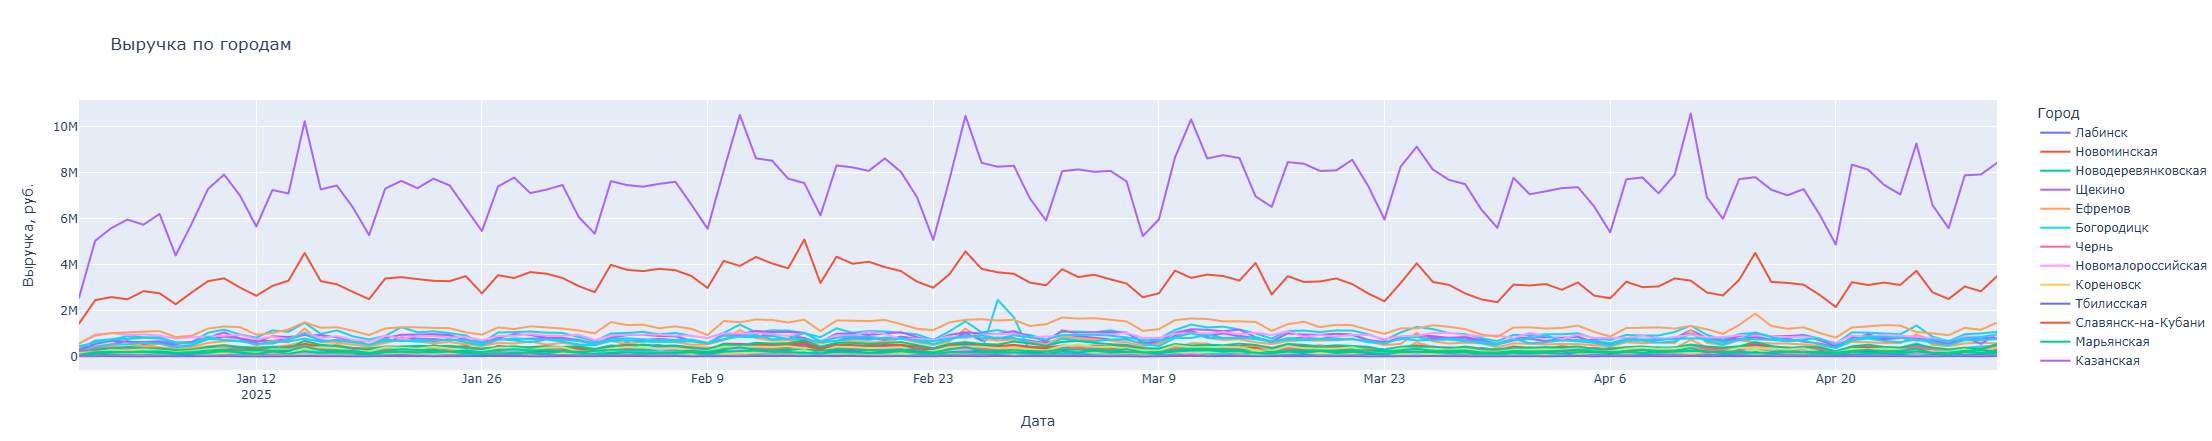

---

In [67]:
avg_by_day_type = (
    season_df.groupby(['City','City_GUID', 'Holiday'])['sum_retail']
    .mean()
    .reset_index(name='AvgRetail')
)
avg_by_day_type

,City,City_GUID,Holiday,AvgRetail
0,Абинск,65fd7905-4522-11eb-80ec-00155d4eea01,0,55562.763158
1,Абинск,65fd7905-4522-11eb-80ec-00155d4eea01,1,48514.809524
2,Абинск,65fd7905-4522-11eb-80ec-00155d4eea01,2,53362.000000
3,Азовская,c72aeceb-4cc8-11ea-80e7-00155d4eea01,0,67265.789474
4,Азовская,c72aeceb-4cc8-11ea-80e7-00155d4eea01,1,58014.261905
...,...,...,...,...
354,Южный,3d1569d2-a267-11eb-80ec-00155d4eea01,1,150577.452381
355,Южный,3d1569d2-a267-11eb-80ec-00155d4eea01,2,163694.500000
356,Ясногорск,5429b33f-b37d-11e4-9bda-001e6728a570,0,388168.513158
357,Ясногорск,5429b33f-b37d-11e4-9bda-001e6728a570,1,302191.833333


Для каждого типа дня рассчитаем коэффициент сезонности, как отношение средней выручки по этому типу к общей средней выручке по всем дням.

In [68]:
# Общая средняя выручка по городам
overall_avg = season_df.groupby('City_GUID')['sum_retail'].mean().reset_index(name='OverallAvg')

# Объединяем и считаем коэффициенты
coefficients = avg_by_day_type.merge(overall_avg, on='City_GUID')
coefficients['SeasonalityCoeff'] = coefficients['AvgRetail'] / coefficients['OverallAvg']

In [69]:
coefficients

,City,City_GUID,Holiday,AvgRetail,OverallAvg,SeasonalityCoeff
0,Абинск,65fd7905-4522-11eb-80ec-00155d4eea01,0,55562.763158,53059.300000,1.047182
1,Абинск,65fd7905-4522-11eb-80ec-00155d4eea01,1,48514.809524,53059.300000,0.914351
2,Абинск,65fd7905-4522-11eb-80ec-00155d4eea01,2,53362.000000,53059.300000,1.005705
3,Азовская,c72aeceb-4cc8-11ea-80e7-00155d4eea01,0,67265.789474,64043.608333,1.050312
4,Азовская,c72aeceb-4cc8-11ea-80e7-00155d4eea01,1,58014.261905,64043.608333,0.905856
...,...,...,...,...,...,...
354,Южный,3d1569d2-a267-11eb-80ec-00155d4eea01,1,150577.452381,161664.808333,0.931418
355,Южный,3d1569d2-a267-11eb-80ec-00155d4eea01,2,163694.500000,161664.808333,1.012555
356,Ясногорск,5429b33f-b37d-11e4-9bda-001e6728a570,0,388168.513158,358497.616667,1.082765
357,Ясногорск,5429b33f-b37d-11e4-9bda-001e6728a570,1,302191.833333,358497.616667,0.842940


Для каждой строки в исходной таблице рассчитаем нормированное значение выручки 

In [70]:
df_normalized = season_df.merge(coefficients[['City_GUID', 'Holiday', 'SeasonalityCoeff']],
                         on=['City_GUID', 'Holiday'])

df_normalized['Normalized_Retail'] = df_normalized['sum_retail'] / df_normalized['SeasonalityCoeff']
df_normalized['Normalized_Retail'] =df_normalized['Normalized_Retail'].round(2)
# округлим до 2 знаком в дробной части, чтобы избежить экспонеты в выводе
df_normalized

,Date,City_GUID,sum_retail,mean_retail,Pharmacy_Count,City,Latitude,Longitude,Week,DayOfWeek,Holiday,MoonPhase,SeasonalityCoeff,Normalized_Retail
0,2025-01-01,01de9f18-ff20-11eb-80f4-00155d4eea01,7610.0,7610.000000,1,Лабинск,44.635315,40.724384,1,3,1,-0.93,0.862360,8824.62
1,2025-01-02,01de9f18-ff20-11eb-80f4-00155d4eea01,8086.0,8086.000000,1,Лабинск,44.635315,40.724384,1,4,1,-0.86,0.862360,9376.59
2,2025-01-03,01de9f18-ff20-11eb-80f4-00155d4eea01,16521.0,16521.000000,1,Лабинск,44.635315,40.724384,1,5,1,-0.79,0.862360,19157.88
3,2025-01-04,01de9f18-ff20-11eb-80f4-00155d4eea01,15932.0,15932.000000,1,Лабинск,44.635315,40.724384,1,6,1,-0.72,0.862360,18474.88
4,2025-01-05,01de9f18-ff20-11eb-80f4-00155d4eea01,22376.0,22376.000000,1,Лабинск,44.635315,40.724384,1,7,1,-0.64,0.862360,25947.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14275,2025-04-30,e84f85bc-3981-11e4-9f08-001e6728a570,3493647.0,52143.985075,67,Краснодар,45.040234,38.976080,18,3,2,-0.83,1.019197,3427842.37
14276,2025-03-07,f4da8c6c-9b03-11e8-80d3-00155d4d8804,192380.0,192380.000000,1,Куркино,53.426895,38.659267,10,5,2,-0.48,1.022128,188215.21
14277,2025-04-30,f4da8c6c-9b03-11e8-80d3-00155d4d8804,157665.0,157665.000000,1,Куркино,53.426895,38.659267,18,3,2,-0.83,1.022128,154251.74
14278,2025-03-07,fa5a3f34-88d9-11ec-80fa-00155d4eea01,30424.0,30424.000000,1,Динская,45.218580,39.223070,10,5,2,-0.48,0.783096,38850.93


In [71]:
df_normalized[['Latitude', 'Longitude']]

,Latitude,Longitude
0,44.635315,40.724384
1,44.635315,40.724384
2,44.635315,40.724384
3,44.635315,40.724384
4,44.635315,40.724384
...,...,...
14275,45.040234,38.976080
14276,53.426895,38.659267
14277,53.426895,38.659267
14278,45.218580,39.223070


<p style="color:green; font-size:24px;">3. Получить в том же разрезе «день-город» данные по температуре и осадкам через api: https://open-meteo.com/en/docs/historical-weather-api</p>

In [72]:
import requests

In [ ]:
# URL API
url = "https://archive-api.open-meteo.com/v1/archive"

# Параметры, которые хотим получить
daily_params = [
    "temperature_2m_max",
    "temperature_2m_min",
    "precipitation_sum",
    "precipitation_hours",
    "daylight_duration"
]

def fetch_weather_for_location(lat, lon, start_date, end_date):
    params = {
        "latitude":  lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,	
        "daily": daily_params
    }    

    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        daily_data = data.get("daily", {})
        return daily_data
    else:
        print(f"Error fetching for {lat}, {lon}: {response.status_code}")
        return None

# Создадим список уникальных мест (координат + города)
unique_locations = df_normalized[['Latitude', 'Longitude']].drop_duplicates()

weather_records = []

for _, loc in unique_locations.iterrows():
    lat = loc['Latitude']
    lon = loc['Longitude']
    
    # Определяем общий период для данного места
    location_dates = df_normalized[(df_normalized['Latitude'] == lat) & (df_normalized['Longitude'] == lon)]
    start_date = location_dates['Date'].min()
    end_date = location_dates['Date'].max()

    # Запрашиваем данные
    weather_data = fetch_weather_for_location(lat, lon, start_date, end_date)
    time.sleep(1)  # Чтобы не перегружать API
    
    if weather_data:
        times = weather_data.get("time", [])
        for i in range(len(times)):
            weather_records.append({
                "date": times[i],
                "latitude": lat,
                "longitude": lon,
                "temp_max": weather_data.get("temperature_2m_max", [None]*len(times))[i],
                "temp_min": weather_data.get("temperature_2m_min", [None]*len(times))[i],
                "precipitation_sum": weather_data.get("precipitation_sum", [None]*len(times))[i],
                "precipitation_hours": weather_data.get("precipitation_hours", [None]*len(times))[i],
                "daylight_duration": weather_data.get("daylight_duration", [None]*len(times))[i]
            })

# Преобразуем в DataFrame
weather_df = pd.DataFrame(weather_records)



<p style="color:green; font-size:24px;">4. Объединить нормированные данные по продажам с погодными метриками в один датафрейм</p>

In [ ]:
# Приводим типы и формат дат
weather_df["date"] = pd.to_datetime(weather_df["date"])
df_normalized["Date"] = pd.to_datetime(df_normalized["Date"])

# Теперь объединяем по дате и координатам
merged_df4 = pd.merge(
    df_normalized,
    weather_df,
    left_on=["Date", "Latitude", "Longitude"],
    right_on=["date", "latitude", "longitude"],
    how="left"
)

In [ ]:
pd.options.display.max_columns=30

In [ ]:
merged_df4

,Date,City_GUID,sum_retail,mean_retail,Pharmacy_Count,City,Latitude,Longitude,ratio,Week,DayOfWeek,Holiday,MoonPhase,SeasonalityCoeff,Normalized_Retail,date,latitude,longitude,temp_max,temp_min,precipitation_sum,precipitation_hours,daylight_duration
0,2025-01-01,01de9f18-ff20-11eb-80f4-00155d4eea01,7610.0,7610.000000,1,Лабинск,44.635315,40.724384,7610.000000,1,3,1,-0.93,0.862360,8824.62,2025-01-01,44.635315,40.724384,10.2,-1.0,0.0,0.0,32023.66
1,2025-01-02,01de9f18-ff20-11eb-80f4-00155d4eea01,8086.0,8086.000000,1,Лабинск,44.635315,40.724384,8086.000000,1,4,1,-0.86,0.862360,9376.59,2025-01-02,44.635315,40.724384,13.5,-2.5,0.0,0.0,32077.20
2,2025-01-03,01de9f18-ff20-11eb-80f4-00155d4eea01,16521.0,16521.000000,1,Лабинск,44.635315,40.724384,16521.000000,1,5,1,-0.79,0.862360,19157.88,2025-01-03,44.635315,40.724384,11.7,-2.8,0.0,0.0,32134.87
3,2025-01-04,01de9f18-ff20-11eb-80f4-00155d4eea01,15932.0,15932.000000,1,Лабинск,44.635315,40.724384,15932.000000,1,6,1,-0.72,0.862360,18474.88,2025-01-04,44.635315,40.724384,13.3,0.3,3.9,6.0,32196.60
4,2025-01-05,01de9f18-ff20-11eb-80f4-00155d4eea01,22376.0,22376.000000,1,Лабинск,44.635315,40.724384,22376.000000,1,7,1,-0.64,0.862360,25947.39,2025-01-05,44.635315,40.724384,0.9,-4.2,0.1,1.0,32262.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14275,2025-04-30,e84f85bc-3981-11e4-9f08-001e6728a570,3493647.0,52143.985075,67,Краснодар,45.040234,38.976080,52143.985075,18,3,2,-0.83,1.019197,3427842.37,2025-04-30,45.040234,38.976080,17.8,5.5,0.0,0.0,51247.57
14276,2025-03-07,f4da8c6c-9b03-11e8-80d3-00155d4d8804,192380.0,192380.000000,1,Куркино,53.426895,38.659267,192380.000000,10,5,2,-0.48,1.022128,188215.21,2025-03-07,53.426895,38.659267,13.2,-0.7,0.0,0.0,40587.39
14277,2025-04-30,f4da8c6c-9b03-11e8-80d3-00155d4d8804,157665.0,157665.000000,1,Куркино,53.426895,38.659267,157665.000000,18,3,2,-0.83,1.022128,154251.74,2025-04-30,53.426895,38.659267,13.8,4.0,0.2,2.0,54055.27
14278,2025-03-07,fa5a3f34-88d9-11ec-80fa-00155d4eea01,30424.0,30424.000000,1,Динская,45.218580,39.223070,30424.000000,10,5,2,-0.48,0.783096,38850.93,2025-03-07,45.218580,39.223070,16.8,-0.5,0.0,0.0,41310.30


<p style="color:green; font-size:24px;">5. Рассчитать коэффициенты корреляции продаж с погодными метриками в полученном наборе данных. Расчет сделать как отдельно для каждого города, так и укрупнить до региона.</p>

In [ ]:
# 1. Присоединяем Region_GUID из TradePoint по City_GUID
tradePoint_unique = tradePoint_df[['City_GUID', 'Region_GUID']].drop_duplicates(subset=['City_GUID'])

# Теперь делаем merge
df_with_region_guid = pd.merge(
    merged_df4,
    tradePoint_unique,
    on='City_GUID',
    how='left'
)

# 2. Присоединяем Region_Name из Regions по Region_GUID
df_with_region_name = pd.merge(
    df_with_region_guid,
    regions_df[['Region_GUID', 'Region_Name']],
    on='Region_GUID',
    how='left'
)

In [ ]:
df_with_region_name

,Date,City_GUID,sum_retail,mean_retail,Pharmacy_Count,City,Latitude,Longitude,ratio,Week,DayOfWeek,Holiday,MoonPhase,SeasonalityCoeff,Normalized_Retail,date,latitude,longitude,temp_max,temp_min,precipitation_sum,precipitation_hours,daylight_duration,Region_GUID,Region_Name
0,2025-01-01,01de9f18-ff20-11eb-80f4-00155d4eea01,7610.0,7610.000000,1,Лабинск,44.635315,40.724384,7610.000000,1,3,1,-0.93,0.862360,8824.62,2025-01-01,44.635315,40.724384,10.2,-1.0,0.0,0.0,32023.66,6c27ee65-f3f3-11e0-b170-001517b157a1,Краснодарский край
1,2025-01-02,01de9f18-ff20-11eb-80f4-00155d4eea01,8086.0,8086.000000,1,Лабинск,44.635315,40.724384,8086.000000,1,4,1,-0.86,0.862360,9376.59,2025-01-02,44.635315,40.724384,13.5,-2.5,0.0,0.0,32077.20,6c27ee65-f3f3-11e0-b170-001517b157a1,Краснодарский край
2,2025-01-03,01de9f18-ff20-11eb-80f4-00155d4eea01,16521.0,16521.000000,1,Лабинск,44.635315,40.724384,16521.000000,1,5,1,-0.79,0.862360,19157.88,2025-01-03,44.635315,40.724384,11.7,-2.8,0.0,0.0,32134.87,6c27ee65-f3f3-11e0-b170-001517b157a1,Краснодарский край
3,2025-01-04,01de9f18-ff20-11eb-80f4-00155d4eea01,15932.0,15932.000000,1,Лабинск,44.635315,40.724384,15932.000000,1,6,1,-0.72,0.862360,18474.88,2025-01-04,44.635315,40.724384,13.3,0.3,3.9,6.0,32196.60,6c27ee65-f3f3-11e0-b170-001517b157a1,Краснодарский край
4,2025-01-05,01de9f18-ff20-11eb-80f4-00155d4eea01,22376.0,22376.000000,1,Лабинск,44.635315,40.724384,22376.000000,1,7,1,-0.64,0.862360,25947.39,2025-01-05,44.635315,40.724384,0.9,-4.2,0.1,1.0,32262.33,6c27ee65-f3f3-11e0-b170-001517b157a1,Краснодарский край
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14275,2025-04-30,e84f85bc-3981-11e4-9f08-001e6728a570,3493647.0,52143.985075,67,Краснодар,45.040234,38.976080,52143.985075,18,3,2,-0.83,1.019197,3427842.37,2025-04-30,45.040234,38.976080,17.8,5.5,0.0,0.0,51247.57,6c27ee65-f3f3-11e0-b170-001517b157a1,Краснодарский край
14276,2025-03-07,f4da8c6c-9b03-11e8-80d3-00155d4d8804,192380.0,192380.000000,1,Куркино,53.426895,38.659267,192380.000000,10,5,2,-0.48,1.022128,188215.21,2025-03-07,53.426895,38.659267,13.2,-0.7,0.0,0.0,40587.39,3b91fd89-8e2d-11de-8009-000e0ce4125a,Тульская область
14277,2025-04-30,f4da8c6c-9b03-11e8-80d3-00155d4d8804,157665.0,157665.000000,1,Куркино,53.426895,38.659267,157665.000000,18,3,2,-0.83,1.022128,154251.74,2025-04-30,53.426895,38.659267,13.8,4.0,0.2,2.0,54055.27,3b91fd89-8e2d-11de-8009-000e0ce4125a,Тульская область
14278,2025-03-07,fa5a3f34-88d9-11ec-80fa-00155d4eea01,30424.0,30424.000000,1,Динская,45.218580,39.223070,30424.000000,10,5,2,-0.48,0.783096,38850.93,2025-03-07,45.218580,39.223070,16.8,-0.5,0.0,0.0,41310.30,6c27ee65-f3f3-11e0-b170-001517b157a1,Краснодарский край


In [ ]:
def calculate_correlations(group, group_name_col):
    sales_vars = ['sum_retail', 'Normalized_Retail']
    weather_vars = ['temp_max', 'temp_min', 'precipitation_sum', 'precipitation_hours', 'daylight_duration']
    
    corr_list = []
    for sale_var in sales_vars:
        corr_row = {group_name_col: group.name}
        corr_row['Sales_Variable'] = sale_var
        for weather_var in weather_vars:
            corr = group[sale_var].corr(group[weather_var])
            corr_row[f'Correlation_{weather_var}'] = round(corr, 3) if not np.isnan(corr) else None
        corr_list.append(corr_row)
    return pd.DataFrame(corr_list)


In [ ]:
city_correlations = df_with_region_name.groupby('City').apply(lambda g: calculate_correlations(g, 'City'))
city_correlations = city_correlations.reset_index(drop=True)

print("Корреляция по городам:")
city_correlations

Корреляция по городам:


,City,Sales_Variable,Correlation_temp_max,Correlation_temp_min,Correlation_precipitation_sum,Correlation_precipitation_hours,Correlation_daylight_duration
0,Абинск,sum_retail,-0.418,-0.414,-0.065,-0.116,-0.156
1,Абинск,Normalized_Retail,-0.426,-0.417,-0.053,-0.073,-0.195
2,Азовская,sum_retail,-0.288,-0.261,0.046,-0.034,-0.114
3,Азовская,Normalized_Retail,-0.282,-0.248,0.066,0.002,-0.150
4,Алексин,sum_retail,-0.025,-0.161,-0.112,-0.200,0.161
...,...,...,...,...,...,...,...
235,Щекино,Normalized_Retail,-0.010,-0.101,0.037,-0.055,0.146
236,Южный,sum_retail,-0.284,-0.354,-0.055,-0.063,-0.249
237,Южный,Normalized_Retail,-0.285,-0.371,-0.027,-0.053,-0.288
238,Ясногорск,sum_retail,0.066,-0.023,0.026,-0.073,0.258


In [ ]:
region_correlations = df_with_region_name.groupby('Region_Name').apply(lambda g: calculate_correlations(g, 'Region_Name'))
region_correlations = region_correlations.reset_index(drop=True)

print("Корреляция по регионам:")
region_correlations

Корреляция по регионам:


,Region_Name,Sales_Variable,Correlation_temp_max,Correlation_temp_min,Correlation_precipitation_sum,Correlation_precipitation_hours,Correlation_daylight_duration
0,Краснодарский край,sum_retail,-0.017,0.013,0.007,0.003,0.000
1,Краснодарский край,Normalized_Retail,-0.017,0.014,0.009,0.007,-0.006
2,Тульская область,sum_retail,0.002,0.007,0.002,-0.007,0.009
3,Тульская область,Normalized_Retail,-0.003,0.004,0.002,-0.005,0.003


<p style="color:green; font-size:24px;">6. Построить тепловую карту корреляций.</p>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_correlation_matrix(df_corr, sales_var='sum_retail', type_var = 'City'):
    # Фильтруем по одному типу продаж
    df_pivot = df_corr[df_corr['Sales_Variable'] == sales_var].copy()
    
    # Убираем лишние префиксы
    df_pivot.columns = df_pivot.columns.str.replace('Correlation_', '')
    
    # Преобразуем в широкий формат
    matrix = df_pivot.drop(columns=['Sales_Variable']).set_index(type_var)
    return matrix

# Создаем матрицу корреляций для 'sum_retail'
corr_matrix_city = create_correlation_matrix(city_correlations, sales_var='sum_retail', type_var = 'City')
corr_matrix_region = create_correlation_matrix(region_correlations, sales_var='sum_retail', type_var = 'Region_Name')

Тепловая карта по городу

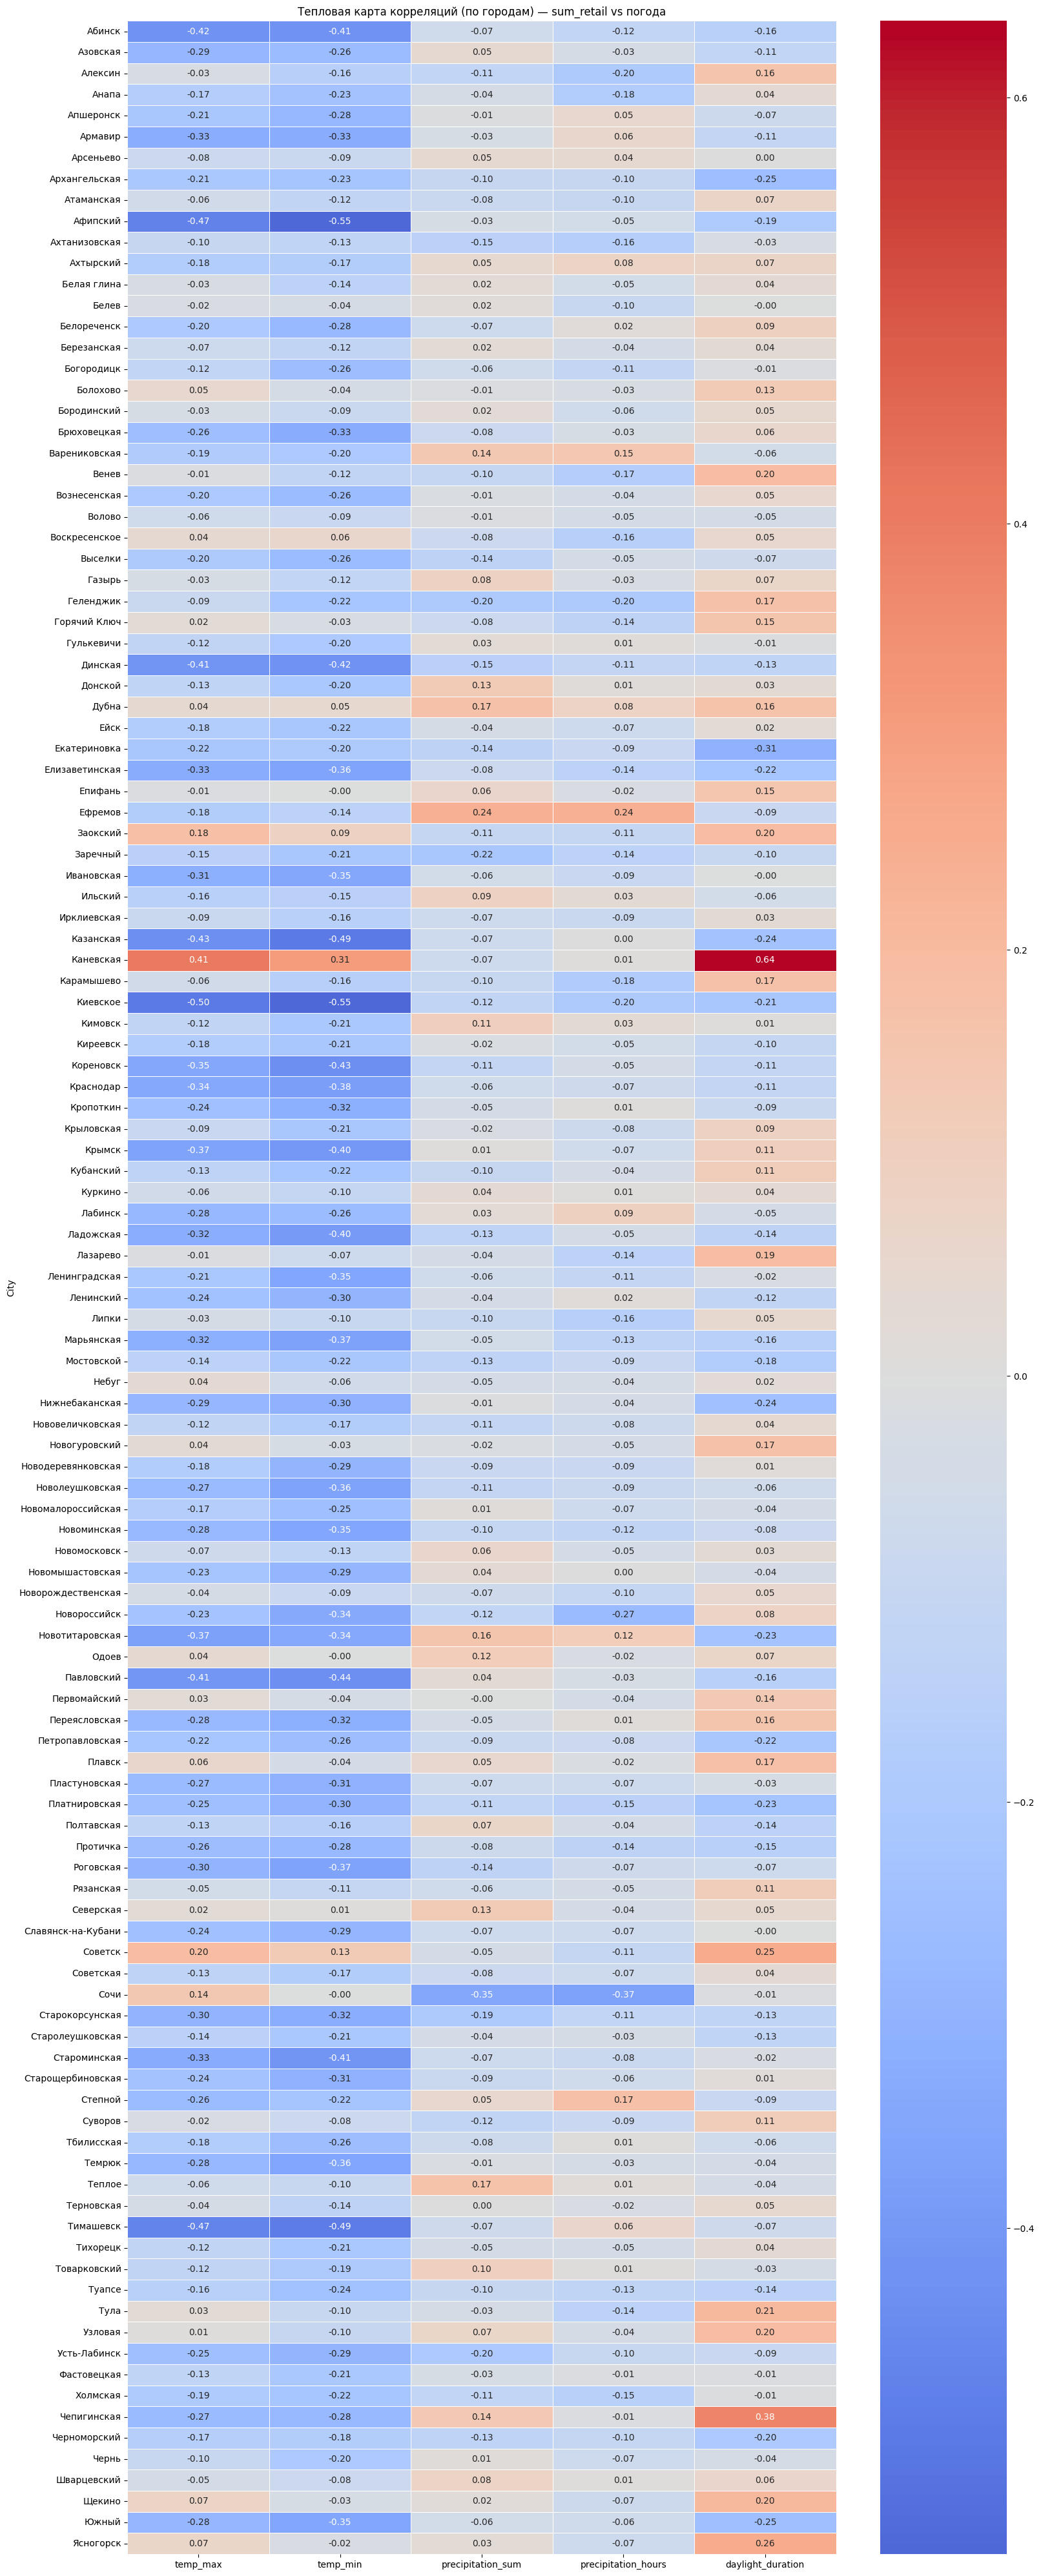

In [ ]:
plt.figure(figsize=(16, 40))
sns.heatmap(corr_matrix_city, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Тепловая карта корреляций (по городам) — sum_retail vs погода')
plt.tight_layout()
plt.show()

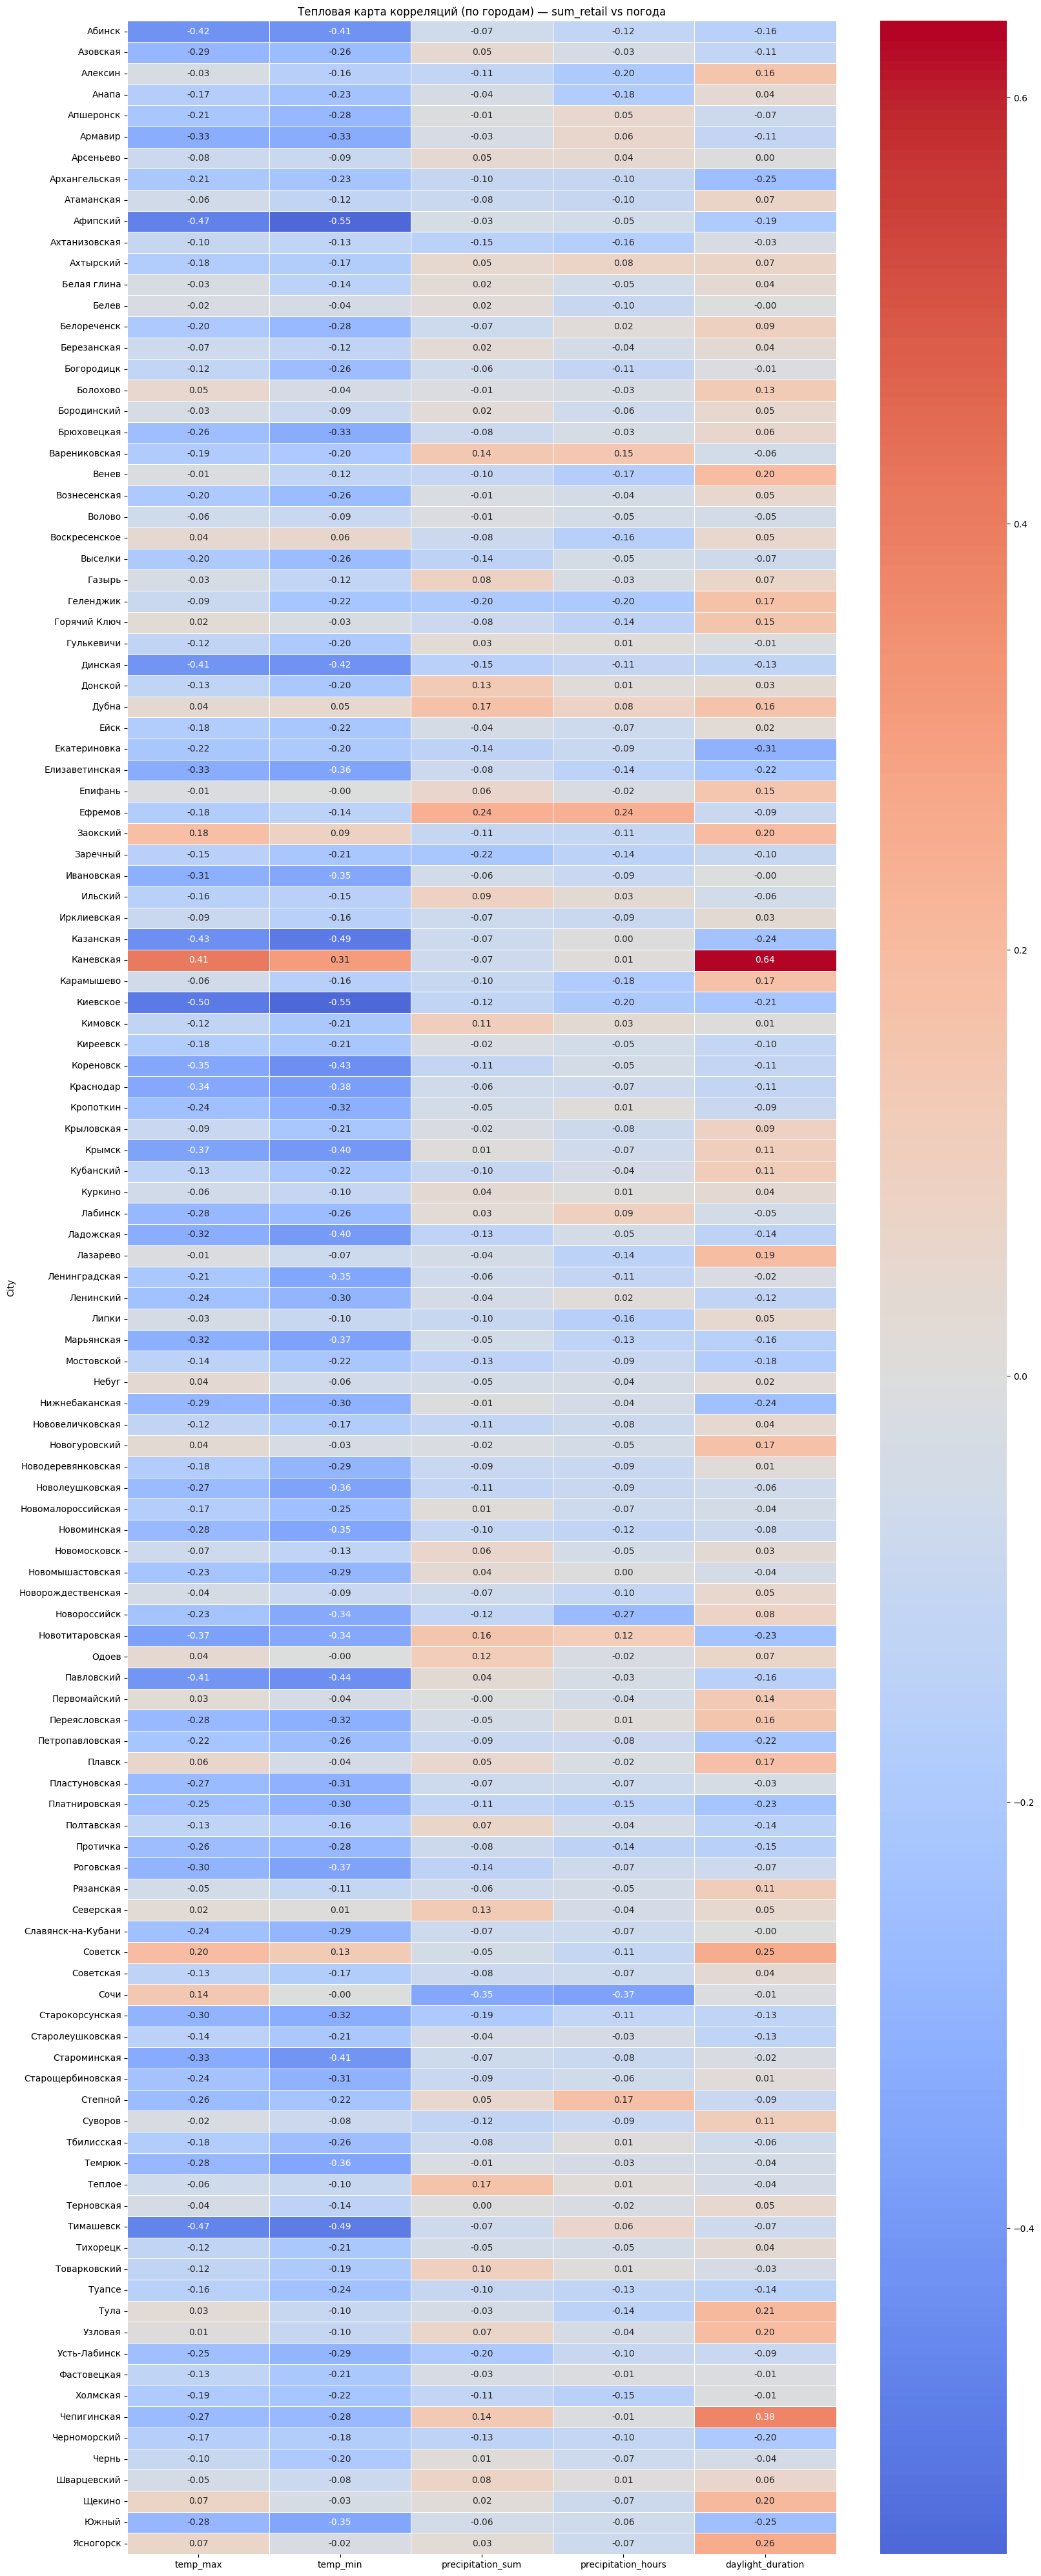

Тепловая карта по региону

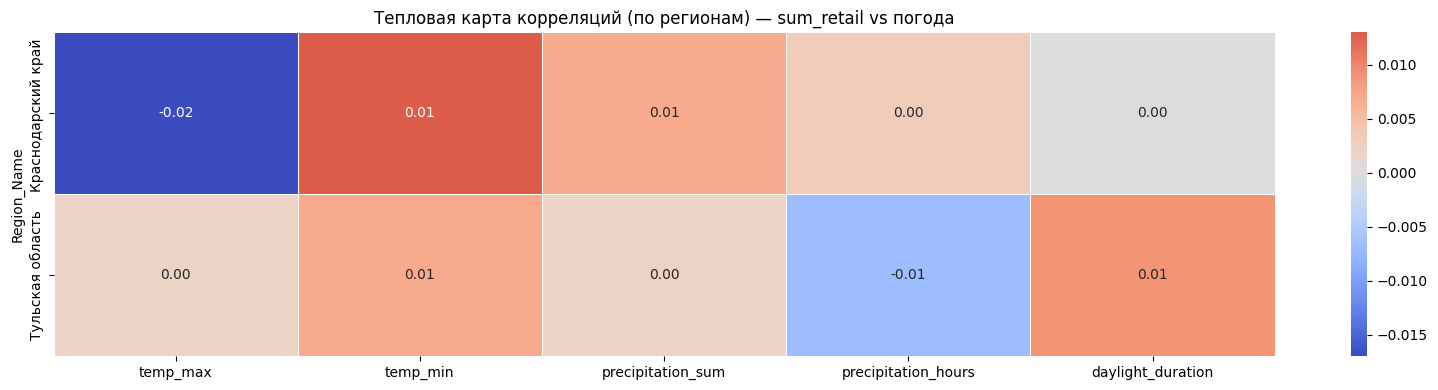

In [ ]:
plt.figure(figsize=(16, 4))
sns.heatmap(corr_matrix_region, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=0.5)
plt.title('Тепловая карта корреляций (по регионам) — sum_retail vs погода')
plt.tight_layout()
plt.show()

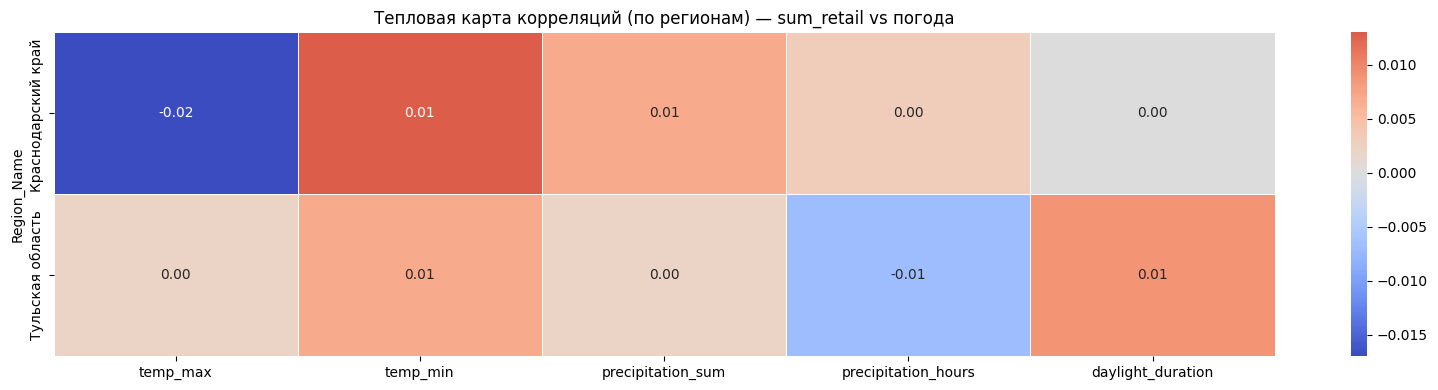

### <p style="color:green; font-size:20px;">7. Резюмировать полученные результаты</p>

Для исследования были взяы следующие показаели погоды:

* temp_max: Максимальная температура
* temp_min: Минимальная температура
* precipitation_sum: Общее количество осадков
* precipitation_hours: Часы с осадками
* daylight_duration: Продолжительность светового дня

ПРи анализе тепловой карты по городам может прослеживаться незначительная корреляция с погодой, положительная или отрицательная, но она очень слабая, даже городах в пределах одного региона значения находятся около 0. Хотя некоторые города показывают наличие хорошей корреляции, например Каневская с продолжительностью светового дня, это скорее всего случайность или ошибка в данных по погоде. Также при получении данных погоды из запроса по api было обнаружено, что данные возвращаются не точно по запрощенным координатам, а с некоторым смещением, что также может вносить шум в данные.

Все значения близки к нулю, что указывает на отсутствие статистически значимой связи между погодными факторами и продажами на уровне регионов.

Причины разницы в корреляциях

1. Агрегация данных на уровне регионов:
При переходе от анализа по городам к анализу по регионам происходит агрегация данных . Это означает, что данные по всем городам внутри региона суммируются или усредняются.
Агрегация может "сглаживать" локальные тенденции, которые были заметны на уровне городов. Например:
Если в одном городе максимальная температура сильно влияет на продажи, а в другом — нет, то на уровне региона эти противоположные эффекты могут компенсировать друг друга, приводя к низкой общей корреляции по региону.

2. Неоднородность городов внутри региона:
Города внутри одного региона могут иметь различные климатические условия и особенности потребительского поведения, численность населения.
Например, в Краснодарском крае есть города с разным микроклиматом (например, побережье Черного моря и внутренние районы). Эти различия могут привести к тому, что погодные факторы влияют по-разному на продажи в разных городах.
При агрегации данных эти различия "смешиваются", что приводит к снижению общей корреляции.

3. Различия в размерах городов:
Большие города могут иметь более выраженную зависимость между погодой и продажами, чем маленькие города. Однако при агрегации данных на уровне региона влияние больших городов может быть "затушено" влиянием множества маленьких городов с менее выраженной корреляцией.

4. Сезонные и региональные особенности:
На уровне городов можно наблюдать сильные сезонные зависимости , которые могут быть связаны с погодными условиями. Например, в летний период высокие температуры могут снижать продажи в некоторых городах.
На уровне региона эти сезонные эффекты могут частично компенсироваться различными климатическими зонами внутри региона, что также приводит к снижению общей корреляции.

5. Шум в данных:
На уровне городов могут быть внутренние собатия или происшетсвия, которые усиливают корреляции. Например, в отдельном городе может произойти событие, которое временно усиливает связь между погодой и продажами.
При агрегации данных на уровень региона этот шум уменьшается, что также приводит к снижению общей корреляции.

6. Наличие других факторов:
На уровне городов погодные факторы могут играть более заметную роль, так как они могут быть одним из основных внешних факторов, влияющих на продажи.
На уровне региона другие факторы (например, экономическое состояние региона, демографические характеристики, маркетинговые кампании) могут доминировать над погодными факторами, что делает последнее влияние менее заметным.

На уровне региона все эти эффекты смешиваются, и общая корреляция становится практически нулевой.

Выводы:
Агрегация данных: Переход от городов к регионам приводит к сглаживанию локальных тенденций, что объясняет снижение корреляций на уровне регионов.

Гетерогенность городов: Различия в климатических условиях и потребительском поведении внутри региона приводят к компенсации различных эффектов, что также снижает корреляции.

Другие факторы: На уровне региона погодные факторы могут оказывать меньшее влияние по сравнению с другими экономическими и социальными факторами.

Более детальная информация по группам продаж лекарственных срество возможно дала бы больше информации, например летом противоаллергические препарата, зимой-осенью прововирусные, где от погодных условий может меняться спрос на те или иные вида препаратов.

В целом, на графике крупных городов как Тула и Краснодар также не замечено тенденций к изменению размера выручки, хотя в данных представлено было частино за 2 сезона(с 2025-01-01 по 2025-04-30) зима и весна.